
<h1 align="center"><font size="5">Project: Clusters of products System</font></h1>
<h2 align="center"><font size="5">Deadline: </font></h2>
<h3 align="center"><font size="5"> Total marks: </font></h3>

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import datetime
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
import scipy
import re

import os,sys
import xlrd
import math

from pandas.plotting import autocorrelation_plot

plt.style.use('ggplot')
%matplotlib inline
from sklearn import decomposition
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise
from matplotlib import pyplot as pyplot
import seaborn as sns
import sklearn.cluster as cluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import time
%matplotlib inline

### About dataset

### Goal

Online shops often sell tons of different items and this can become very messy very quickly!
Data science can be extremely useful to automatically organize the products in categories so that they can be easily found by the customers.
The goal of this challenge is to look at user purchase history and create categories of items that are likely to be bought together and, therefore, should belong to the same section.

### Description

Company XYZ is an online grocery store. In the current version of the website, they have manually grouped the items into a few categories based on their experience.
However, they now have a lot of data about user purchase history. Therefore, they would like to put the data into use! This is what they asked you to do:

●	The company founder wants to meet with some of the best customers to go through a focus group with them. You are asked to send the ID of the following customers to the founder:

    ○	the customer who bought the most items overall in her lifetime

    ○	for each item, the customer who bought that product the most
    
●	Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.


● purchase_history

| Field          | Description                                                                                             |
|----------------|---------------------------------------------------------------------------------------------------------|
| user_id        | the Id of the user.                                                                                     |                            
| id             | id of item which customers bought                                                                       |    

● item_to_id

| Field          | Description                                                                                             |
|----------------|---------------------------------------------------------------------------------------------------------|
| Item_id        | the Id of the item                                                                                      |
| Item_name      | name of item                                                                                            |

# 1. Data Exploration

### 1.1 Load Data From CSV File  

In [2]:
# Read CSV file: loan_train.csv
purchase = pd.read_csv('purchase_history.csv')
items = pd.read_csv('item_to_id.csv')

In [3]:
# Understanding to dataset
# Shape
print(purchase.shape)
print(items.shape)

(39474, 2)
(48, 2)


In [4]:
# head()
purchase.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [5]:
purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
user_id    39474 non-null int64
id         39474 non-null object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


In [6]:
items.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [7]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
Item_name    48 non-null object
Item_id      48 non-null int64
dtypes: int64(1), object(1)
memory usage: 848.0+ bytes


### 1.2 Preprocessing data

In [8]:
dic_item = items.set_index('Item_id').to_dict()['Item_name']
print(dic_item.values())

dict_values(['coffee', 'tea', 'juice', 'soda', 'sandwich loaves', 'dinner rolls', 'tortillas', 'bagels', 'canned vegetables', 'spaghetti sauce', 'ketchup', 'cheeses', 'eggs', 'milk', 'yogurt', 'butter', 'cereals', 'flour', 'sugar', 'pasta', 'waffles', 'frozen vegetables', 'ice cream', 'poultry', 'beef', 'pork', 'bananas', 'berries', 'cherries', 'grapefruit', 'apples', 'broccoli', 'carrots', 'cauliflower', 'cucumbers', 'lettuce', 'laundry detergent', 'dishwashing\xa0', 'paper towels', 'toilet paper', 'aluminum foil', 'sandwich bags', 'shampoo', 'soap', 'hand soap', 'shaving cream', 'baby items', 'pet items'])


In [9]:
print('Unique users:', len(purchase['user_id'].unique()))
print('Total number of transactions in purchase history:', len(purchase['user_id']))

Unique users: 24885
Total number of transactions in purchase history: 39474


In [10]:
print('Có', len(purchase['user_id'])- len(purchase['user_id'].unique()),' users thực hiện nhiều hơn 1 giao dịch mua hàng')

Có 14589  users thực hiện nhiều hơn 1 giao dịch mua hàng


In [11]:
#...Appending "," at the end of each id to add the strings later
purchase['id'] = purchase['id'].apply(lambda x: x + ',')
purchase.head()

,user_id,id
0,222087,"27,26,"
1,1343649,"6,47,17,"
2,404134,"18,12,23,22,27,43,38,20,35,1,"
3,1110200,"9,23,2,20,26,47,37,"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [12]:
# Grouping the products purchsed by each customer separately using groupby
group_user = purchase.groupby('user_id')['id'].agg('sum').reset_index()

In [13]:
print(group_user.shape)

(24885, 2)


In [14]:
print(group_user.head())

   user_id                                    id
0       47  3,4,2,13,44,16,24,28,23,45,15,46,25,
1       68               23,10,42,39,19,6,17,25,
2      113       46,33,30,32,43,9,38,21,15,3,25,
3      123                           4,10,27,18,
4      223        1,6,35,29,41,45,32,17,2,22,38,


In [15]:
# Removing comma (,) and converting the string into list containing integers
group_user['id'] = group_user['id'].apply(lambda x: list(map(int,x[:-1].split(','))))
group_user.head()

,user_id,id
0,47,"[3, 4, 2, 13, 44, 16, 24, 28, 23, 45, 15, 46, 25]"
1,68,"[23, 10, 42, 39, 19, 6, 17, 25]"
2,113,"[46, 33, 30, 32, 43, 9, 38, 21, 15, 3, 25]"
3,123,"[4, 10, 27, 18]"
4,223,"[1, 6, 35, 29, 41, 45, 32, 17, 2, 22, 38]"


In [16]:
# Creating a Frequency Distribution of each item purchased by individual Customer
item_name  = items.Item_name.to_list()
columns = ['id'] + ['item_'+str(i) for i  in range(1,49)]
purchase_data = pd.DataFrame(columns = columns)

In [17]:
user_amount = len(group_user)
for i in range(user_amount):
    items_list = group_user.id[i]
    #print(items_list)
    row = [group_user.user_id[i]]
    #print(row)
    for number in range(1,49):
        count = 0
        for item in items_list:
            if item == number:
                count = count + 1
            else:
                count = count
        row.append(count)
    purchase_data = purchase_data.append(pd.Series(row, index = columns), ignore_index = True)


In [18]:
purchase_data.head()

,id,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,...,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48
0,47,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
1,68,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,113,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
3,123,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,223,1,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [19]:
purchase_data.to_csv('prepare_data.csv', index = False)

### 1.4 Data exploration

#### 1.4.1 Finding the Total No. of items purchased by each customer

In [20]:
prepare_data = pd.read_csv('prepare_data.csv')
col_list = purchase_data.columns.to_list()
col_list.remove('id')
purchase_data['item_count'] = purchase_data[col_list].sum(axis =1)
purchase_data.head()

,id,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,...,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_count
0,47,0,1,1,1,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,13.0
1,68,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,8.0
2,113,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,11.0
3,123,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
4,223,1,1,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,11.0


#### 1.4.2 Finding the customer_id with max. purchasal count

In [21]:
max_customer_index = purchase_data['item_count'].idxmax()
max_purchase_id = purchase_data['id'].iloc[max_customer_index]

print("The Customer id who bought the most items overall in her lifetime is: {}".format(max_purchase_id))
purchase_data[purchase_data['item_count'] == purchase_data['item_count'].max()]

The Customer id who bought the most items overall in her lifetime is: 269335


,id,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,...,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_count
4445,269335,1,5,2,1,0,3,0,0,4,...,1,2,4,1,2,0,1,1,1,72.0


#### 1.4.2 Finding the list of customers who bought each item max. No. of times

In [22]:
qua_max = pd.DataFrame(columns = ['Item_id', 'customer_id'])
for col in col_list:
    max_quan_cus = purchase_data[col].max()
    cus_id = purchase_data['id'].iloc[max_quan_cus]
    row = pd.Series([int(col.split('_')[-1]),cus_id], index = ['Item_id','customer_id'])
    qua_max = qua_max.append(row, ignore_index = True)
    qua_max['Item_id'] = pd.to_numeric(qua_max['Item_id'])
    

In [23]:
final_output = pd.merge(qua_max, items, on='Item_id')
final_output

,Item_id,customer_id,Item_name
0,1,223,sugar
1,2,281,lettuce
2,3,223,pet items
3,4,123,baby items
4,5,123,waffles
5,6,223,poultry
6,7,123,sandwich bags
7,8,123,butter
8,9,223,soda
9,10,223,carrots


In [24]:
# Saving the results to a csv file
final_output.to_csv('each_item_max_purchase_customer_id.csv',index=False)

In [25]:
final_output[['customer_id','Item_name']].groupby('customer_id').count()

,Item_name
customer_id,
113,1
123,15
223,27
281,5


#### Cluster items based on user co-purchase history

In [26]:
def fit_kmeans(data,n):
    kmeans = KMeans(n_clusters = n, random_state = 0)
    kmeans.fit(data)
    return kmeans

In [27]:
prepare_data
customer_data = pd.read_csv('prepare_data.csv')
customer_data = customer_data.drop(['id'], axis = 1)
transpose_matrix = customer_data.T
MSD_dict = {}
for n in range(1,48):
    MSD_dict[n] = fit_kmeans(transpose_matrix,n).inertia_/len(transpose_matrix)
print(MSD_dict)

{1: 5437.965711805594, 2: 5144.253682170543, 3: 4981.582589285715, 4: 4844.010981912145, 5: 4513.574857026143, 6: 4366.020202020202, 7: 4319.411739864867, 8: 3915.578973765431, 9: 3922.595269097221, 10: 3816.9902510683746, 11: 3585.307531130266, 12: 3503.8214962121215, 13: 3379.159722222224, 14: 3184.958055555555, 15: 3064.5566123188414, 16: 3015.0937500000014, 17: 2846.94816468254, 18: 2681.5880681818176, 19: 2561.7306547619046, 20: 2435.475694444445, 21: 2306.529513888889, 22: 2183.914999999999, 23: 2088.759548611111, 24: 1974.3766666666663, 25: 1854.727430555555, 26: 1744.3958333333333, 27: 1649.7215909090908, 28: 1526.3849206349212, 29: 1418.239583333334, 30: 1321.4254385964916, 31: 1221.3229166666663, 32: 1097.1004901960787, 33: 1002.875, 34: 906.5472222222223, 35: 822.2263257575755, 36: 694.7852564102564, 37: 624.1979166666669, 38: 547.5895833333334, 39: 489.7770833333334, 40: 428.0364583333333, 41: 370.7552083333333, 42: 314.12326388888886, 43: 257.2552083333333, 44: 201.5260416

In [28]:
from matplotlib import style
style.use('fivethirtyeight')

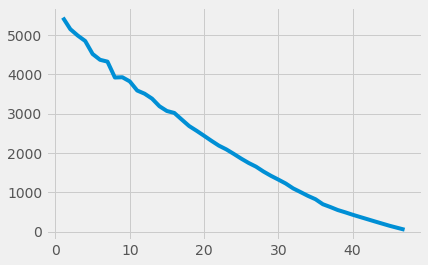

In [29]:
plt.plot(list(MSD_dict.keys()),list(MSD_dict.values()))

In [30]:
kmeans = fit_kmeans(transpose_matrix,12)
cluster_map = pd.DataFrame()
cluster_map['Item_id'] = transpose_matrix.index.values
cluster_map['cluster_no'] = kmeans.labels_
cluster_map

,Item_id,cluster_no
0,item_1,8
1,item_2,9
2,item_3,7
3,item_4,8
4,item_5,8
5,item_6,6
6,item_7,1
7,item_8,8
8,item_9,3
9,item_10,2


In [31]:
cluster_map['Item_id'] = cluster_map['Item_id'].apply(lambda x: int(x.split('_')[-1]))
output = pd.merge(cluster_map, items, on = 'Item_id')
output = output.sort_values('cluster_no',ascending = True)
output = output.reset_index(drop = True)
output

,Item_id,cluster_no,Item_name
0,36,0,ice cream
1,24,1,paper towels
2,7,1,sandwich bags
3,33,1,toilet paper
4,15,1,aluminum foil
5,45,2,cauliflower
6,42,2,cucumbers
7,10,2,carrots
8,23,3,tea
9,43,3,coffee


In [32]:
output.to_csv('clustered_dataframe.csv',index=False)